In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


# Correlation matrix

First of all, applying dimensionality reduction techniques, such as PCA requires highly correlated features to give significant results. If there is high correlations among predictor variables, it can negatively impact the performance of certains algorithms.

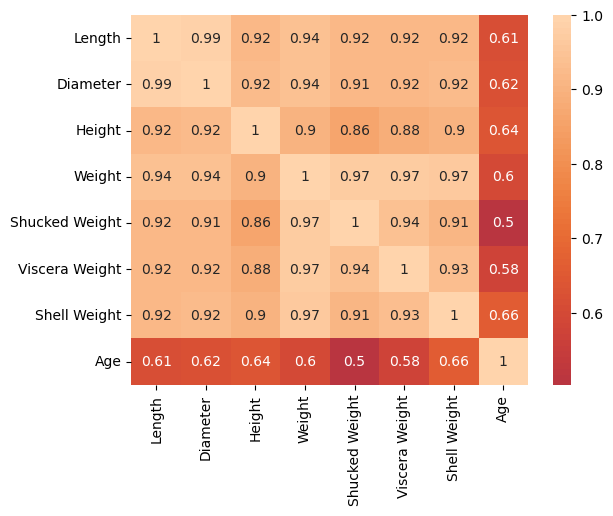

In [3]:
corr = df.drop(columns=['id', 'Sex']).corr()
sns.heatmap(corr, center=0, annot=True)
plt.show()

As we can see, there is HUGE correlation between predictor variables in this dataset. It is worth to examine some techniques, such as PCA.

In [4]:
y = df['Age']
X = df.drop(columns=['Age', 'id'])

X = pd.get_dummies(X, columns=['Sex'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Dimensionality reduction
Firstly, let's start with PCA. Principal Component Analysis is a method to transform dataset to lower-dimensional space, trying to retain as much information as possible.

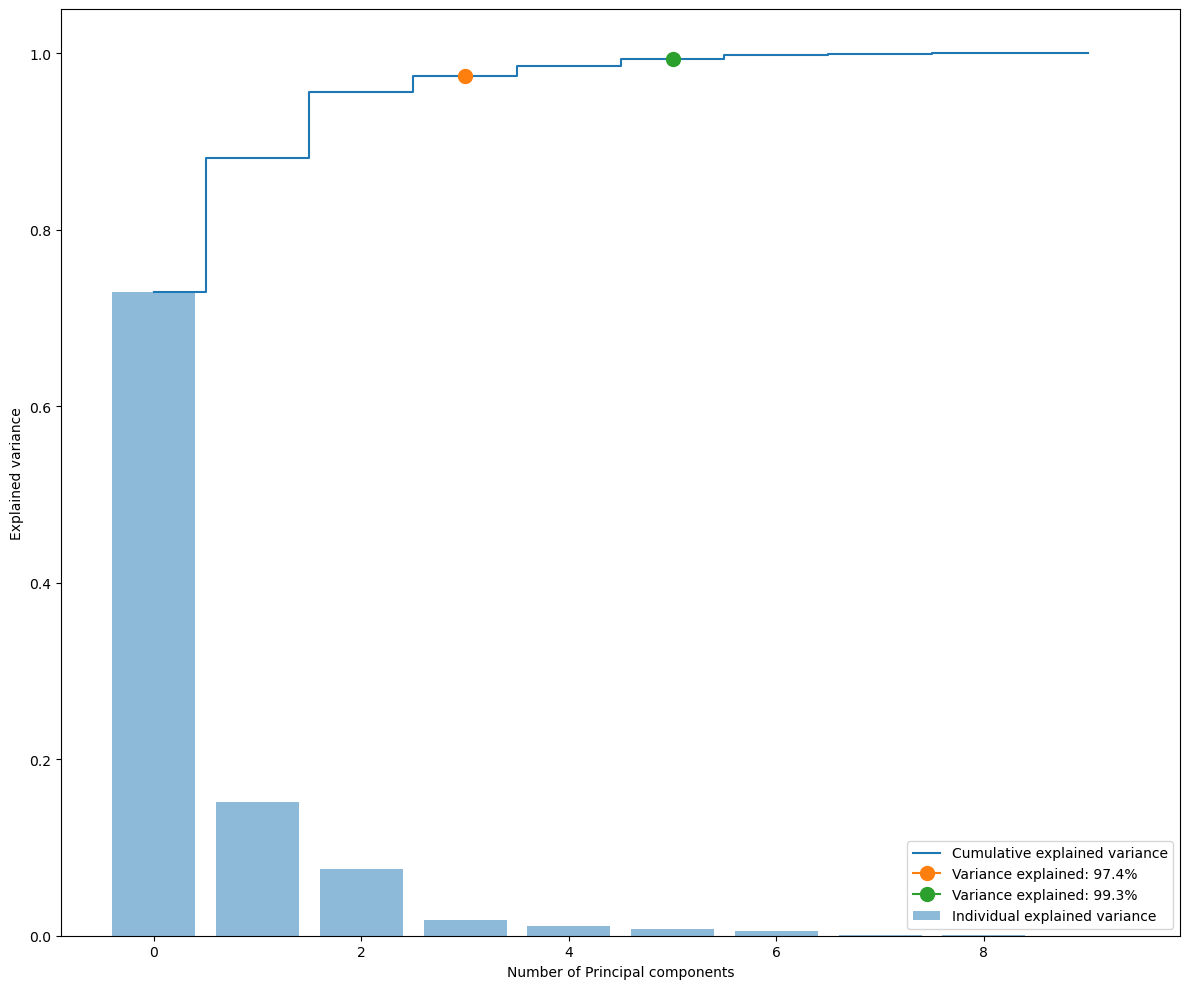

In [5]:
#data should be standarized before applaying PCA
scaler = StandardScaler()
X_train_std  =scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

#explained variance by each feature
exp_var_pca = pca.explained_variance_ratio_

#cumulative sum of explained variance array
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(12, 10))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.plot(3, cum_sum_eigenvalues[3], marker='o', 
         markersize=10, label=f'Variance explained: {cum_sum_eigenvalues[3] * 100:.1f}%')
plt.plot(5, cum_sum_eigenvalues[5], marker='o', 
         markersize=10, label=f'Variance explained: {cum_sum_eigenvalues[5]* 100:.1f}%')

plt.ylabel('Explained variance')
plt.xlabel('Number of Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

It looks like using 4 principal components can explain up to 97.5% of variance!

In [6]:
df = pd.get_dummies(df, columns=['Sex'])

# Visualizing PCA on 3D spcae

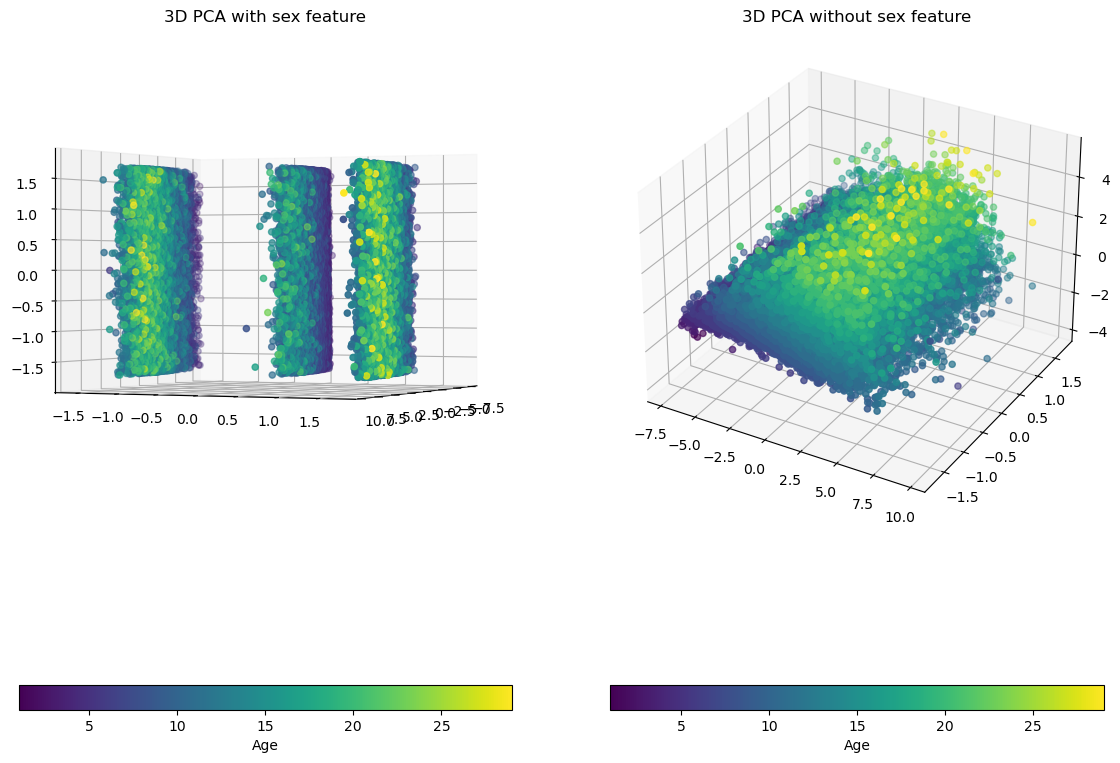

In [7]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(121, projection='3d')
scaler = StandardScaler()
X_train_std  =scaler.fit_transform(df)
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y)
ax.set_title('3D PCA with sex feature')
fig.add_axes(ax)
ax.view_init(0, 25)
plt.colorbar(plt.cm.ScalarMappable(norm = plt.Normalize(vmin = df['Age'].min(), vmax = df['Age'].max())),
             ax = ax, orientation = "horizontal", label='Age')

#second plot without using the sex features
ax = fig.add_subplot(122, projection='3d')
scaler = StandardScaler()
X_train_std  =scaler.fit_transform(df.drop(columns=['Sex_F', 'Sex_I', 'Sex_M']))
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y)
plt.colorbar(plt.cm.ScalarMappable(norm = plt.Normalize(vmin = df['Age'].min(), vmax = df['Age'].max())),
             ax = ax, orientation = "horizontal", label='Age')
ax.set_title('3D PCA without sex feature')
fig.add_axes(ax)

plt.show()

PCA should be used on numerical data, using it on categorical data is not the best option. Even after encoding the data, PCA still strongly relay on the 3 unique values.

# Training after PCA

Let's create simple cross validation training example and examine how number of principal components influence average validation loss.

In [8]:
df = df.drop(columns=['Age', 'id'])


Training using whole dataset, without any dimensionality reduction techniques.

In [9]:
losses = []
n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True, random_state=123)
for fold, (train_idx, val_idx) in enumerate(kf.split(df, y)):
    X_train, y_train = df.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = df.iloc[val_idx], y.iloc[val_idx]
    
    model =  CatBoostRegressor(verbose=False, objective='MAE')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    val_preds = model.predict(X_val)
    loss = mean_absolute_error(y_val, np.round(val_preds))
    losses.append(loss)

val_avg_loss = sum(losses) / n_splits
print(f'avg_pred using normal dataset: {val_avg_loss:.4f}')

avg_pred using normal dataset: 1.3443


For simplicity, let's create pipeline containg scaler, pca and regressor.

In [10]:
for num_components in range(1, len(df.columns)):
    losses = []
    n_splits = 5
    kf = KFold(n_splits=n_splits,shuffle=True, random_state=123)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df, y)):
        X_train, y_train = df.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = df.iloc[val_idx], y.iloc[val_idx]
        
        pipe = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(n_components=num_components)),
                         ('clf', CatBoostRegressor(verbose=False, objective='MAE'))])
 
        pipe.fit(X_train, y_train)
        val_preds = pipe.predict(X_val)
        loss = mean_absolute_error(y_val, np.round(val_preds))
        losses.append(loss)

    val_avg_loss = sum(losses) / n_splits
    print(f'num components: {num_components} avg_pred: {val_avg_loss:.4f}')

num components: 1 avg_pred: 1.5819
num components: 2 avg_pred: 1.5113
num components: 3 avg_pred: 1.4575
num components: 4 avg_pred: 1.4454
num components: 5 avg_pred: 1.4437
num components: 6 avg_pred: 1.3714
num components: 7 avg_pred: 1.3676
num components: 8 avg_pred: 1.3673
num components: 9 avg_pred: 1.3515


Reducing dimensionality of the train dataset by half gives simillar results in 5kfold cross validations as using all features.